In [1]:
# Decision Tree — Real-time Flight Delay Prediction (≥15 min)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score
)

# Load data
PATH = "/content/AllData_Mergedfinal.csv"
df = pd.read_csv(PATH)

In [2]:
delay_col = "Departure delay (Minutes)"
df[delay_col] = pd.to_numeric(df[delay_col], errors="coerce")

# Binary target: delay ≥ 15 minutes
df["DelayFlag"] = (df[delay_col] >= 15).astype(int)

# Make sure elapsed time is numeric
df["Scheduled elapsed time (Minutes)"] = pd.to_numeric(
    df["Scheduled elapsed time (Minutes)"], errors="coerce"
)

# Extract departure hour from "HH:MM"
def to_hour(x):
    try:
        return int(str(x).split(":")[0])
    except Exception:
        return np.nan

df["DepHour"] = df["Scheduled departure time"].apply(to_hour)

# Keep only needed columns and drop missing
keep_cols = [
    "Carrier Code",
    "Destination Airport",
    "Scheduled elapsed time (Minutes)",
    "DepHour",
    "DelayFlag"
]
df_model = df[keep_cols].dropna().copy()

In [3]:
# downsample for speed
if len(df_model) > 100_000:
    df_model = df_model.sample(n=100_000, random_state=42)

print("Data used for modeling:", df_model.shape)

Data used for modeling: (43853, 5)


In [4]:
# Features & target
X = df_model.drop(columns=["DelayFlag"])
y = df_model["DelayFlag"].astype(int)

cat_cols = ["Carrier Code", "Destination Airport"]
num_cols = ["Scheduled elapsed time (Minutes)", "DepHour"]


In [5]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [6]:
# Preprocessing + Model
preprocess = ColumnTransformer(
    transformers=[

        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=10,
    random_state=42
)

pipe = Pipeline(steps=[("prep", preprocess), ("model", clf)])

# Fit model
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Carrier Code',
                                                   'Destination Airport']),
                                                 ('num', 'passthrough',
                                                  ['Scheduled elapsed time '
                                                   '(Minutes)',
                                                   'DepHour'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=6, min_samples_split=10,
                                        random_state=42))])

In [12]:
# Evaluation
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

print("=== Decision Tree — Metrics (Delay ≥15 min) ===")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

=== Decision Tree — Metrics (Delay ≥15 min) ===
Accuracy:  0.789
Precision: 0.294
Recall:    0.004
F1-score:  0.007
ROC AUC:   0.648

Classification Report:
              precision    recall  f1-score   support

           0      0.791     0.998     0.882     10399
           1      0.294     0.004     0.007      2757

    accuracy                          0.789     13156
   macro avg      0.542     0.501     0.445     13156
weighted avg      0.687     0.789     0.699     13156



In [13]:
# Feature Names and Importances
from sklearn.tree import plot_tree

# fitted OneHotEncoder from the pipeline
ohe = pipe.named_steps["prep"].named_transformers_["cat"]

# feature names created by the encoder
cat_feature_names = ohe.get_feature_names_out(cat_cols)

# Combine categorical and numeric feature names
feature_names = np.concatenate([cat_feature_names, num_cols])

# Extract feature importances
importances = pipe.named_steps["model"].feature_importances_

# DataFrame and sort
fi = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

<Figure size 500x400 with 0 Axes>

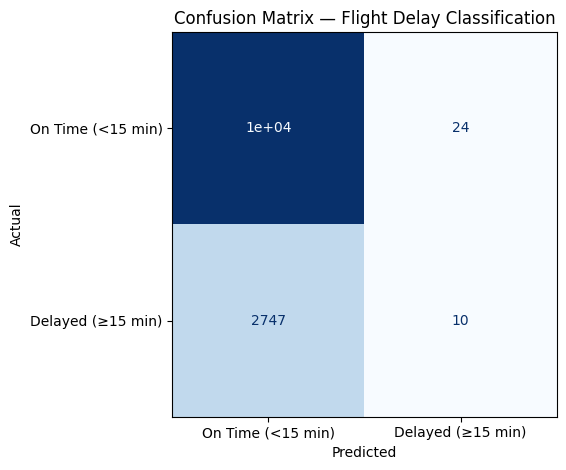

In [14]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["On Time (<15 min)", "Delayed (≥15 min)"],
    cmap="Blues",
    colorbar=False
)
plt.title("Confusion Matrix — Flight Delay Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


<Figure size 600x500 with 0 Axes>

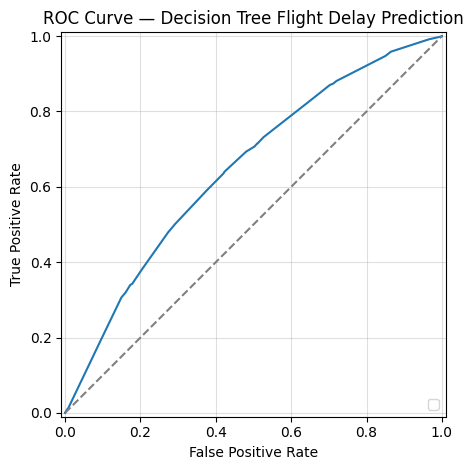

In [15]:
# ROC Curve
from sklearn.metrics import roc_curve, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve — Decision Tree Flight Delay Prediction")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

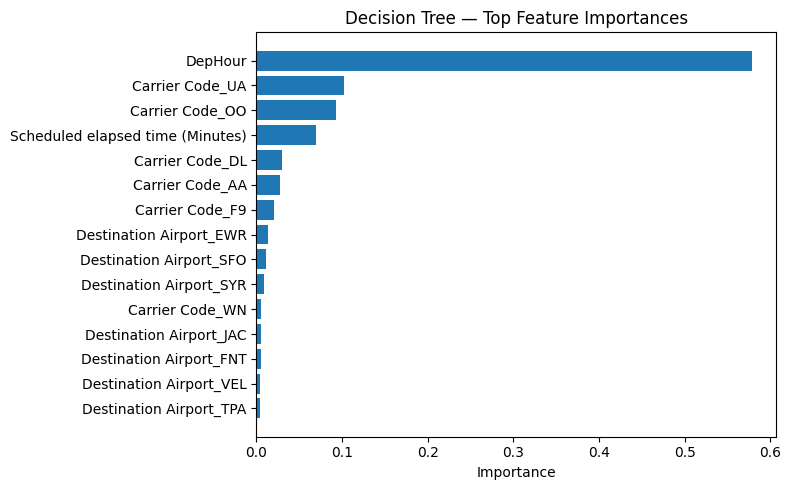

In [16]:
# bar plot of top feature importances
topN = 15
plt.figure(figsize=(8, 5))
plt.barh(
    fi.head(topN)["feature"][::-1],
    fi.head(topN)["importance"][::-1]
)
plt.xlabel("Importance")
plt.title("Decision Tree — Top Feature Importances")
plt.tight_layout()
plt.show()

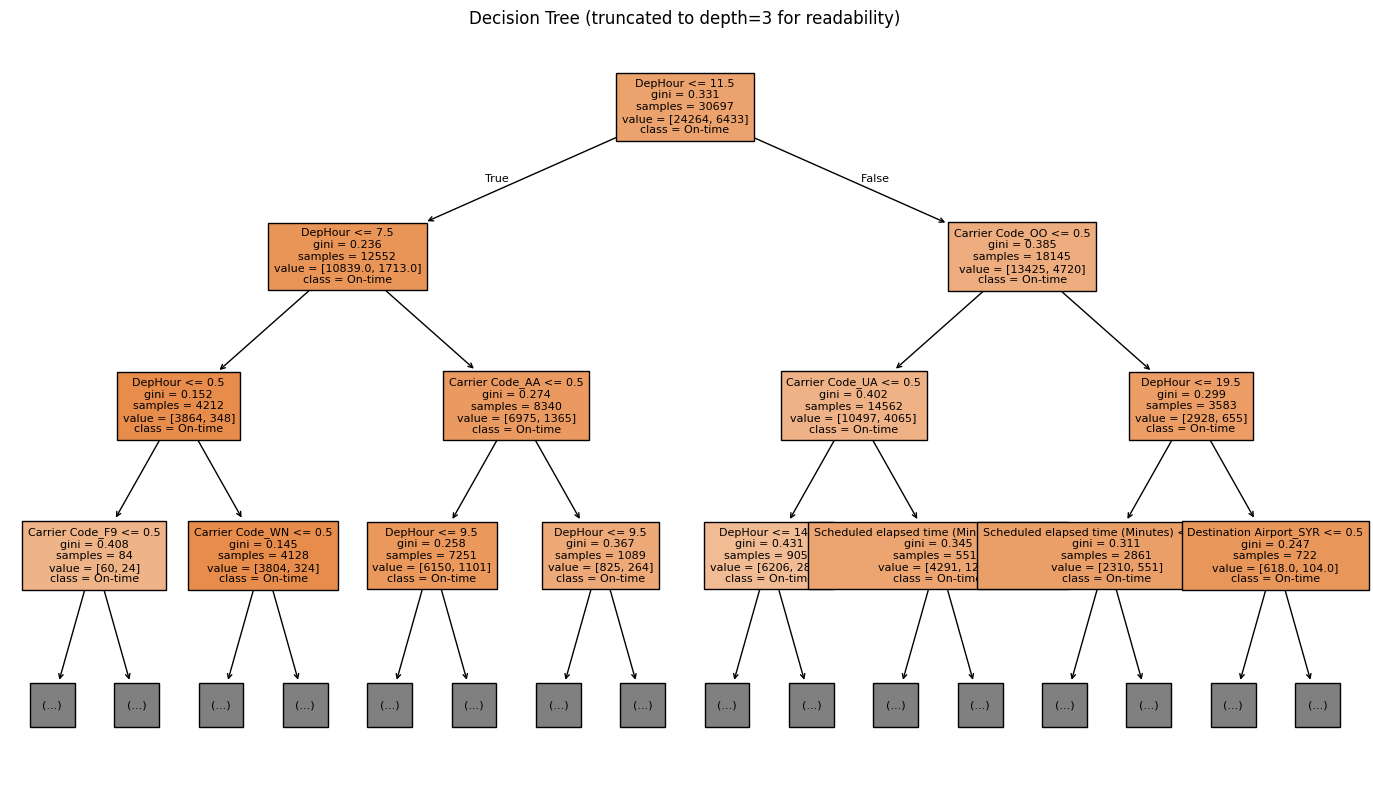

In [17]:
# Visualize the tree
plt.figure(figsize=(14, 8))
plot_tree(
    pipe.named_steps["model"],
    feature_names=feature_names,
    class_names=["On-time", "Delayed"],
    filled=True,
    max_depth=3,
    fontsize=8
)
plt.title("Decision Tree (truncated to depth=3 for readability)")
plt.tight_layout()
plt.show()

**Why this model was chosen:** A Decision Tree classifier was used to predict whether a flight would be delayed by 15 minutes or more using only pre-departure information (carrier, destination airport, scheduled elapsed time, and departure hour). This model was appropriate because it handles both categorical and numeric features, generates clear if-then decision rules that are easy to interpret, and provides feature-importance scores to show which flight characteristics contribute most to delay risk.

**Model assumptions:** The Decision Tree does not require linear or normally distributed data, but it assumes the training set reflects real delay patterns and that the features provide enough signal to distinguish delayed from on-time flights. Limiting tree depth and minimum split size helps enforce the assumption that a simple set of rules can model real-time delay behavior without overfitting.

**Data Preparation:** The dataset was filtered to include only information available before take-off to support real-time delay prediction. A binary target (DelayFlag) was created for delays ≥15 minutes, and departure hour was extracted from the scheduled time. Only pre-departure features (carrier, destination, scheduled elapsed time, and departure hour) were retained, and rows with missing values were removed. Categorical variables were one-hot encoded and numeric variables passed through directly, resulting in a clean feature set suitable for evaluating delay prediction without using future or post-flight data.

**Hyperparameter tuning:** A shallow tree was used (max_depth=6, min_samples_split=10) to balance interpretability and generalization. These settings were chosen as reasonable defaults rather than through grid search, since the goal was to test simple real-time prediction rules rather than maximize accuracy. More complex models (e.g., Random Forests or Gradient Boosting) could be explored in future work to improve delay recall.

**Challenges & solutions:** The main challenge was extreme class imbalance because most flights were on time. So the model could achieve high accuracy simply by predicting “on-time,” which is reflected in the confusion matrix where most true delays were missed. To keep the model efficient, only core pre-departure features were used and categorical fields were one-hot encoded. Feature importance results show that departure hour is the strongest predictor, followed by carrier and scheduled elapsed time, indicating that time of day and airline identity are the most informative factors for real-time delay prediction.

**Perfromance and Evalaution:** On the test set, the model reached 0.79 accuracy and 0.65 ROC AUC, but performance on the delayed class was very weak (precision ≈ 0.29, recall ≈ 0.00). The confusion matrix shows that the tree correctly predicts most on-time flights but rarely flags true delays, and the ROC curve indicates only modest predictive signal. Overall, with only basic pre-departure information, the model can reliably identify on-time flights but cannot predict delays accurately, suggesting the need for richer real-time data or more advanced models.